# Preprocessing the data and training bidirectional LSTM model

* Import libraries and load data from 'preprocessing-and-training-lstm' notebook

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [3]:
file_path = 'data/processed/data_for_models.pkl'
data = pd.read_pickle(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16530 entries, 2024-01-01 00:00:00 to 2025-11-28 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   count       16530 non-null  int64         
 1   day         16530 non-null  datetime64[ns]
 2   month       16530 non-null  int32         
 3   year        16530 non-null  int32         
 4   dayof week  16530 non-null  int32         
 5   holiday     16530 non-null  int64         
 6   SNOW        16530 non-null  string        
 7   TMAX        16530 non-null  string        
 8   TMIN        16530 non-null  string        
 9   PRCP        16530 non-null  string        
 10  SNWD        16530 non-null  string        
dtypes: datetime64[ns](1), int32(3), int64(2), string(5)
memory usage: 1.3 MB


In [4]:
target = data['count'].values.astype(float)  #using number of departures as target

In [5]:
target

array([137., 296., 198., ..., 129.,  84.,  87.])

In [6]:
target.shape

(16530,)

In [7]:
#normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1)) #minmax scaler does not assume the data has a specific distribution shape
target_normalized = scaler.fit_transform(target.reshape(-1, 1))

In [8]:
len(target) - 12
#0 to 16517

#for in 0,...,16517

16518

In [9]:
#create sequences
def create_sequences(target, seq_length):
    xs = []
    ys = []
    for i in range(len(target) - seq_length):
        x = target[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  #trying sequence length of 12 hours
X, y = create_sequences(target_normalized, seq_length)


In [10]:
#indices = seq_length to len(target)

In [11]:
indices = data.index[12:]

In [12]:
#perform train/test split (70/30)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
#convert to pytorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [14]:
len(y_test)

4956

In [15]:
indices_test = indices[train_size:]

In [16]:
indices_test

DatetimeIndex(['2025-04-27 12:00:00', '2025-04-27 13:00:00',
               '2025-04-27 14:00:00', '2025-04-27 15:00:00',
               '2025-04-27 16:00:00', '2025-04-27 17:00:00',
               '2025-04-27 18:00:00', '2025-04-27 19:00:00',
               '2025-04-27 20:00:00', '2025-04-27 21:00:00',
               ...
               '2025-11-28 14:00:00', '2025-11-28 15:00:00',
               '2025-11-28 16:00:00', '2025-11-28 17:00:00',
               '2025-11-28 18:00:00', '2025-11-28 19:00:00',
               '2025-11-28 20:00:00', '2025-11-28 21:00:00',
               '2025-11-28 22:00:00', '2025-11-28 23:00:00'],
              dtype='datetime64[ns]', name='start_hour', length=4956, freq=None)

In [17]:
X_test.shape

torch.Size([4956, 12, 1])

In [18]:
#X_train

In [19]:
#make a custom dataset for a DataLoader
class BikeshareDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Bidirectional LSTM

In [20]:
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(BiLSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 # Bidirectional means 2 directions

        # Define the bidirectional LSTM layer
        # batch_first=True makes input/output tensors of shape (batch, seq, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True)
        
        # Define a linear layer for the output (e.g., a regression output)
        # The input size to the linear layer is hidden_size * num_directions
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        # Shape: (num_layers * num_directions, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM
        # out shape: (batch_size, seq_length, hidden_size * num_directions)
        #out, _ = self.lstm(x, (h0, c0))
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply linear layer to all time steps
        # For sequence generation/forecasting where you need output at each step
        out = self.fc(out[:, -1, :])
        
        return out

In [21]:
train_dataset = BikeshareDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [22]:
#instantiate model, loss, optimizer
model = BiLSTMRegressor()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
learning_rate = 0.001
num_epochs = 100

# Training Loop
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.003120
Epoch [20/100], Loss: 0.008923
Epoch [30/100], Loss: 0.003638
Epoch [40/100], Loss: 0.000641
Epoch [50/100], Loss: 0.000532
Epoch [60/100], Loss: 0.005142
Epoch [70/100], Loss: 0.004940
Epoch [80/100], Loss: 0.001455
Epoch [90/100], Loss: 0.002409
Epoch [100/100], Loss: 0.000695


In [23]:
#evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = loss_fn(y_pred_test, y_test)
    print(f'Test Loss: {test_loss.item():.6f}')

Test Loss: 0.004572


In [24]:
#inverse transform to get predicted values from test
y_pred_test = scaler.inverse_transform(y_pred_test.numpy())
y_test = scaler.inverse_transform(y_test.numpy())

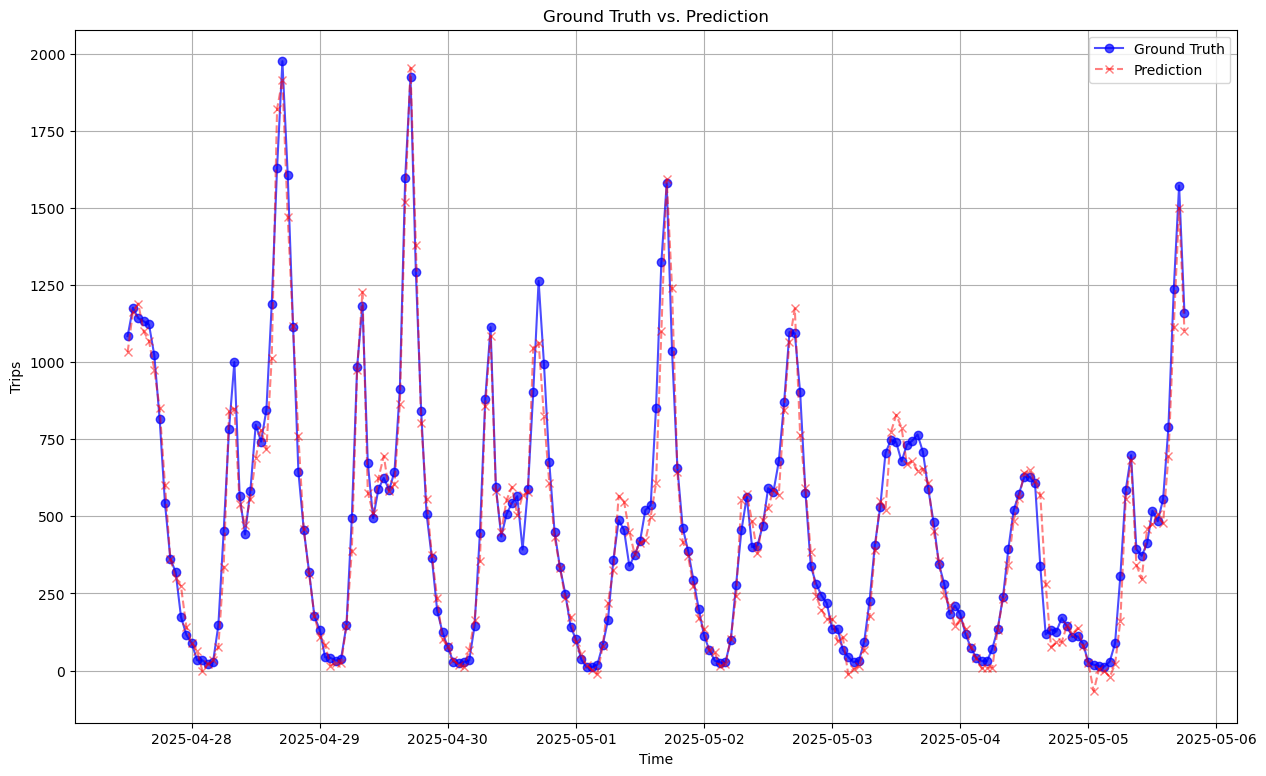

In [25]:
ground_truth_df = pd.DataFrame(y_test[0:199], index=indices_test[0:199])
prediction_df = pd.DataFrame(y_pred_test[0:199], index=indices_test[0:199])

# Plotting
plt.figure(figsize=(15, 9))
plt.plot(ground_truth_df, label='Ground Truth', color='blue', marker='o', alpha=0.7)
plt.plot(prediction_df, label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Trips')
plt.title('Ground Truth vs. Prediction')
plt.legend()
plt.grid(True)
plt.show()

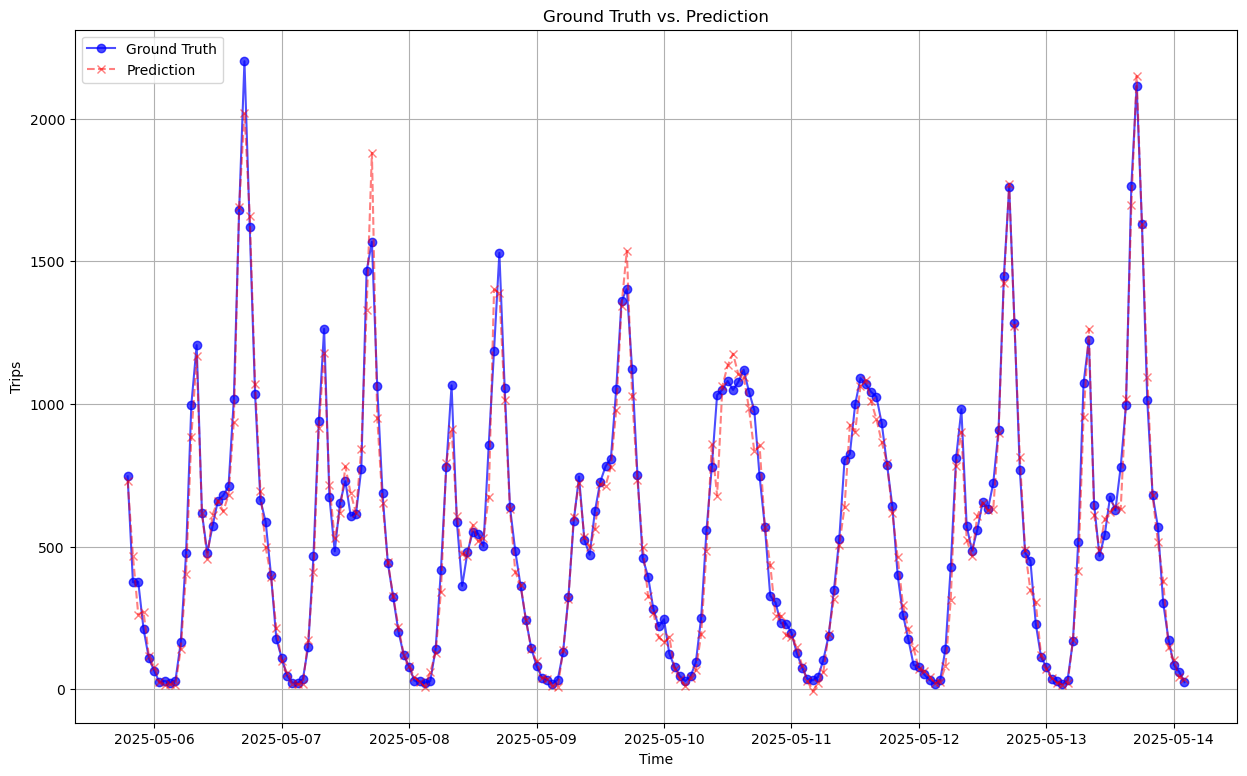

In [26]:
ground_truth_df_2 = pd.DataFrame(y_test[199:399], index=indices_test[199:399])
prediction_df_2 = pd.DataFrame(y_pred_test[199:399], index=indices_test[199:399])

# Plotting
plt.figure(figsize=(15, 9))
#ground_truth_df.plot(label='Ground Truth', color='blue', marker='o', alpha=0.7)
#prediction_df.plot(label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)
plt.plot(ground_truth_df_2, label='Ground Truth', color='blue', marker='o', alpha=0.7)
plt.plot(prediction_df_2, label='Prediction', color='red', linestyle='--', marker='x', alpha=0.5)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Trips')
plt.title('Ground Truth vs. Prediction')
plt.legend()
plt.grid(True)
plt.show()